In [1]:
# Chosen using results from Heart-K
epsilon = 1.0 #technically, this might want to be readjusted because it is a different representation
k = 3

input_dim = 13
num_clusters = 9
num_classes = 2

model_file = "Model/model/perplexity_10_regularizer_0.001_batch_size_409_learning_rate_0.01_latent_dimension_2_activation_ELU_seed_1_iter_3000.ckpt"

feature_names = ["age", "sex", "cp", "trestbps", "chol", "fbs", "restecg", "thalach", "exang", "oldpeak", "slope", "ca", "thal"]

import csv
import json
import numpy as np
import os
import pandas as pd

os.system("rm *.png")

import sys
sys.path.insert(0, "../Code/")
from explain_cs import explain
from load_scvis import load_vae
from metrics import metrics, eval_epsilon
from myplot import plot_polys, plot_groups, plot_metrics, plot_explanation, plot_change
from misc import poly2labels

def load_model(input_dim = input_dim, model_file = model_file):
    return load_vae(input_dim, model_file)


The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



In [2]:
# Load Data & Configuration

x = pd.read_csv("../Heart/Data/X_corrupted.tsv", sep="\t").values

labels = pd.read_csv("../Heart/Data/labels_corrupted.tsv", sep="\t").values


In [3]:
# Calculate Data Representation

sess, rep, X, D = load_model()

data_rep = sess.run(rep, feed_dict={X: x, D: np.zeros((1, input_dim))})




Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.



INFO:tensorflow:Restoring parameters from Model/model/perplexity_10_regularizer_0.001_batch_size_409_learning_rate_0.01_latent_dimension_2_activation_ELU_seed_1_iter_3000.ckpt


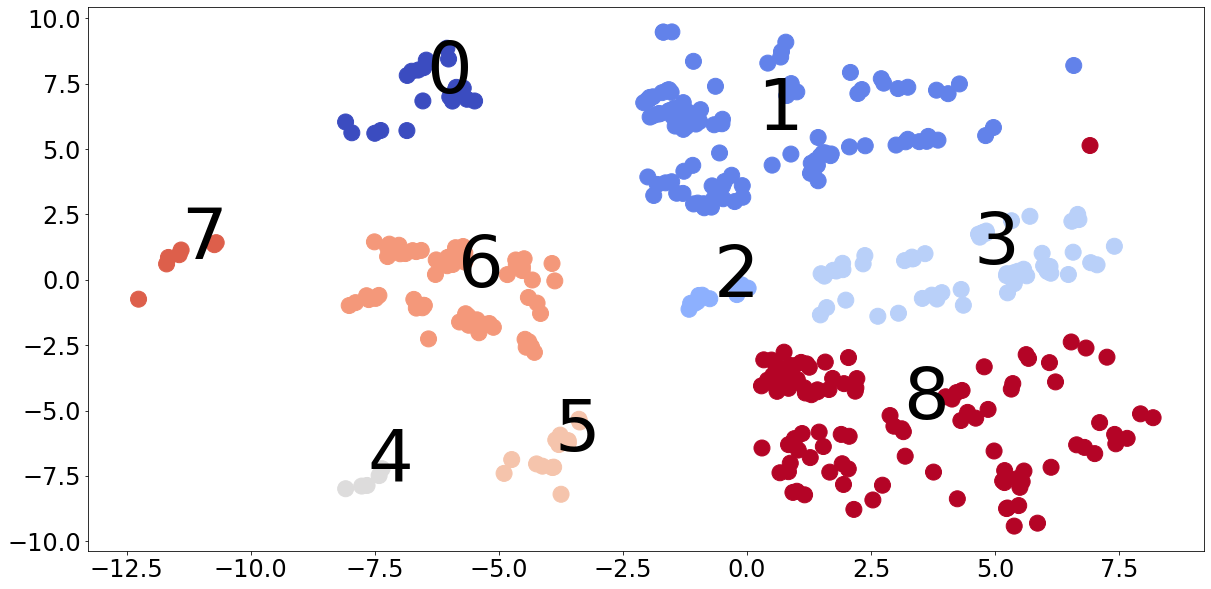

In [4]:
# Visualize the clusters in the learned representation

means, centers, indices = plot_groups(x, data_rep, num_clusters, labels, name = "heart-retrained-rep.png")


In [5]:
# Set epsilon for our metrics

if True:
    os.system("rm epsilon.txt")
    eval_epsilon(load_model, x, indices, epsilon)


INFO:tensorflow:Restoring parameters from Model/model/perplexity_10_regularizer_0.001_batch_size_409_learning_rate_0.01_latent_dimension_2_activation_ELU_seed_1_iter_3000.ckpt


In [6]:
# Compute the group explanations

run = False

if run:
    os.system("rm deltas.npy")
    
    best_val = 0.0
    for lg in [0.0, 0.5, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5, 5.0]:
        for trial in range(5):

            deltas = explain(load_model, means, centers, learning_rate = 0.01, consecutive_steps = 5, lambda_global = lg)
            a, b = metrics(load_model, x, indices, deltas, epsilon, k = k) 

            val = np.mean(a)

            if val > best_val:
                best_val = val
                np.save("deltas.npy", deltas)

            os.system("rm -rf explanation")
           

INFO:tensorflow:Restoring parameters from Model/model/perplexity_10_regularizer_0.001_batch_size_409_learning_rate_0.01_latent_dimension_2_activation_ELU_seed_1_iter_3000.ckpt


../Code/myplot.py:105: MatplotlibDeprecationWarning: Since 3.2, mpl_toolkits's own colorbar implementation is deprecated; it will be removed two minor releases later.  Set the 'mpl_toolkits.legacy_colorbar' rcParam to False to use Matplotlib's default colorbar implementation and suppress this deprecation warning.
  ax.cax.colorbar(im)
/Users/abhijith/opt/miniconda3/envs/fact/lib/python3.7/site-packages/mpl_toolkits/axes_grid1/axes_grid.py:46: MatplotlibDeprecationWarning: 
The mpl_toolkits.axes_grid1.colorbar module was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use matplotlib.colorbar instead.
  from .colorbar import Colorbar


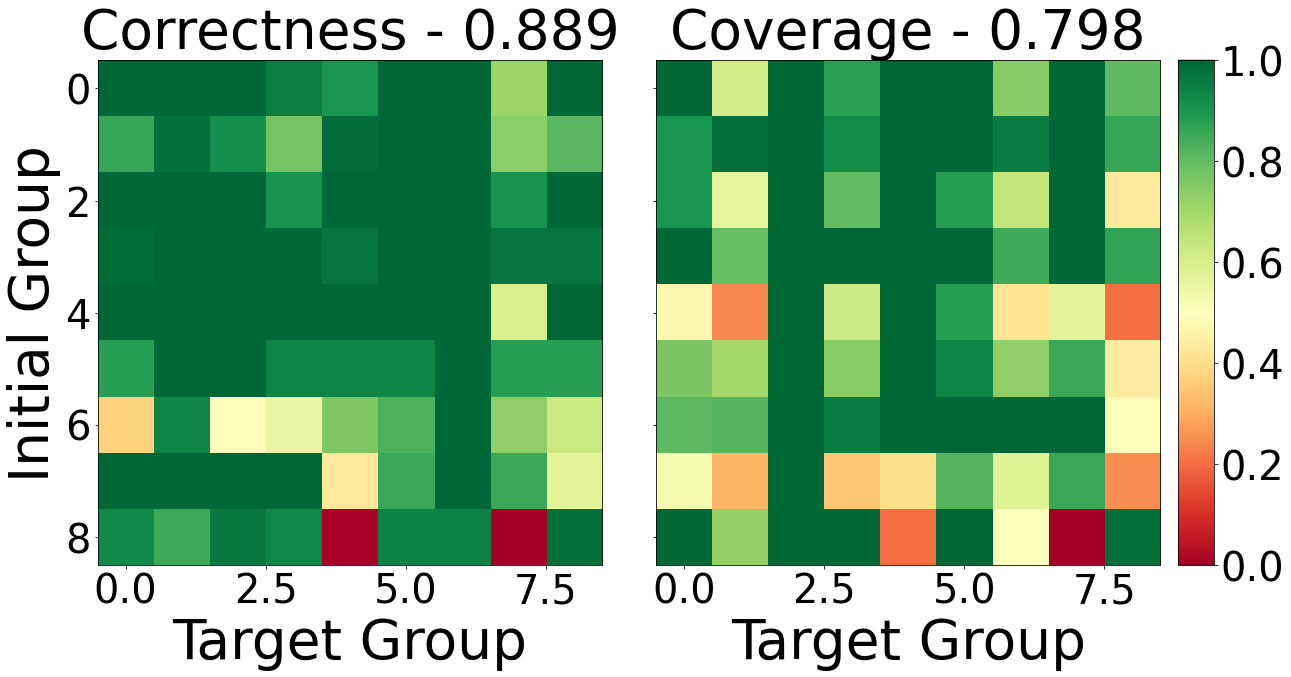

In [7]:
# Evaluate the explanations

deltas = np.load("deltas.npy")

a, b = metrics(load_model, x, indices, deltas, epsilon, k = k)

plot_metrics(a, b, name = "heart-retrained-metrics.png")


INFO:tensorflow:Restoring parameters from Model/model/perplexity_10_regularizer_0.001_batch_size_409_learning_rate_0.01_latent_dimension_2_activation_ELU_seed_1_iter_3000.ckpt
INFO:tensorflow:Restoring parameters from Model/model/perplexity_10_regularizer_0.001_batch_size_409_learning_rate_0.01_latent_dimension_2_activation_ELU_seed_1_iter_3000.ckpt


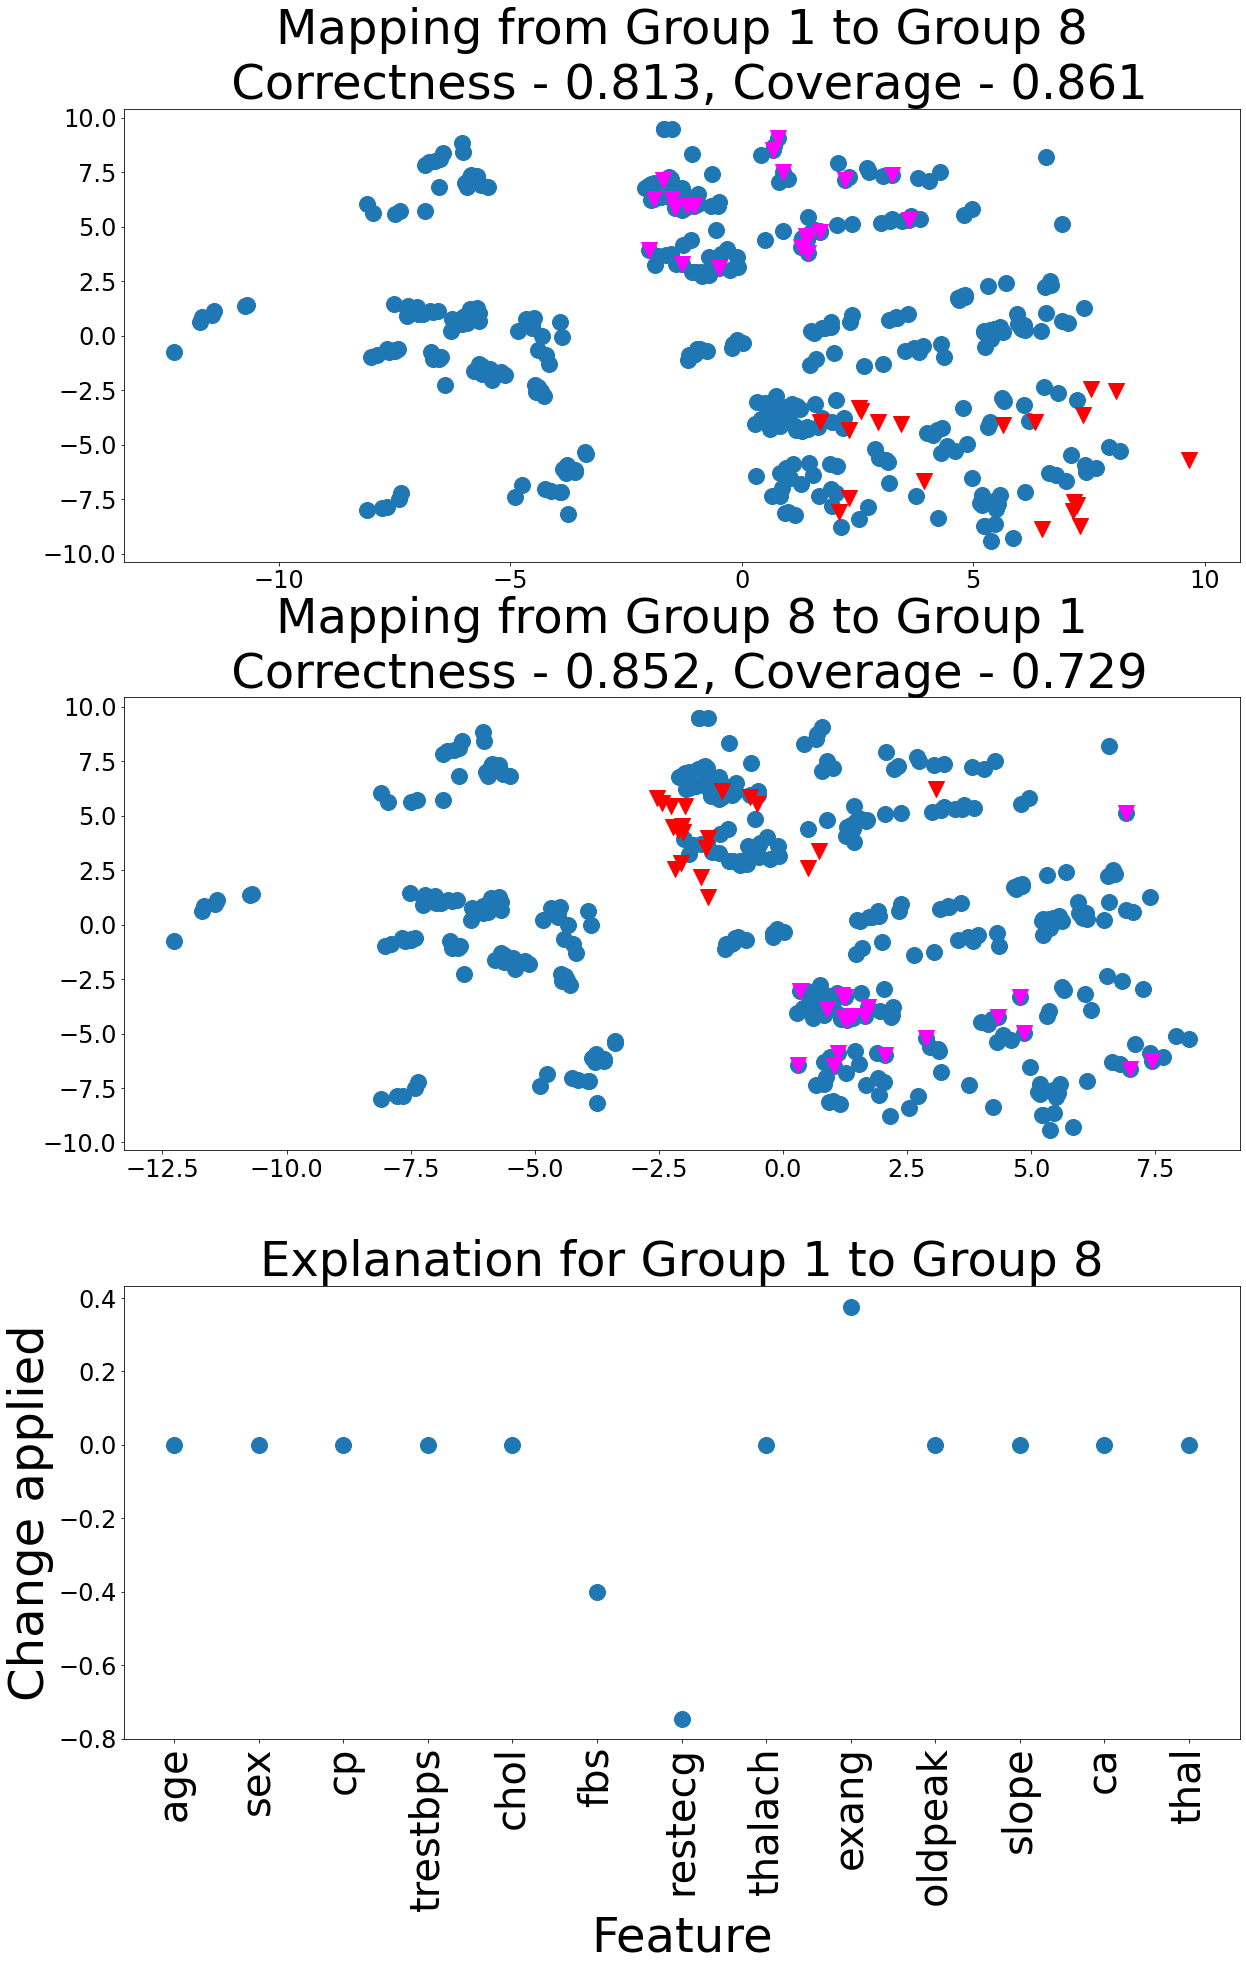

In [8]:
# Visualize the group explanations


plot_explanation(load_model, x, data_rep, indices, deltas, a, b, 1, 8, k = k, name = "heart-retrained-t2c.png", num_points = 20, feature_names = feature_names)


[[ 0.    0.01 -0.08 -0.   -0.   -0.99  0.    0.    0.05 -0.    0.09 -0.02
  -0.01]
 [-0.    0.04 -0.29  0.    0.   -0.01 -0.01 -0.01  1.04  0.   -0.06  0.03
   0.  ]
 [ 0.    0.01 -0.33  0.   -0.   -0.86 -0.   -0.    1.11  0.    0.    0.
  -0.  ]
 [ 0.   -0.93 -0.3  -0.    0.   -0.04 -0.03  0.    1.07  0.   -0.01 -0.01
   0.  ]
 [ 0.   -0.97 -0.27  0.   -0.   -0.96 -0.    0.    1.01 -0.    0.01 -0.01
  -0.  ]
 [ 0.   -0.96 -0.11 -0.   -0.   -0.91 -0.    0.    0.01  0.    0.07 -0.02
  -0.  ]
 [ 0.   -1.01 -0.    0.   -0.    0.    0.   -0.   -0.01 -0.    0.12 -0.
   0.  ]]
[[-0.    0.15 -0.09 -0.   -0.   -0.71 -0.08  0.01  0.13 -0.   -0.   -0.06
  -0.01]
 [-0.   -0.1  -0.28 -0.    0.   -0.15  0.   -0.03  0.85 -0.   -0.01  0.05
   0.  ]
 [-0.    0.   -0.27  0.   -0.   -1.   -0.03 -0.    0.97  0.   -0.04  0.05
   0.01]
 [ 0.   -1.1  -0.36  0.   -0.   -0.14 -0.06 -0.    0.88 -0.   -0.11  0.05
   0.  ]
 [-0.   -0.89 -0.27 -0.    0.   -0.79 -0.02 -0.    1.12 -0.   -0.14  0.03
  -0.  ]
 [ 0.  

ValueError: The number of FixedLocator locations (14), usually from a call to set_ticks, does not match the number of ticklabels (13).

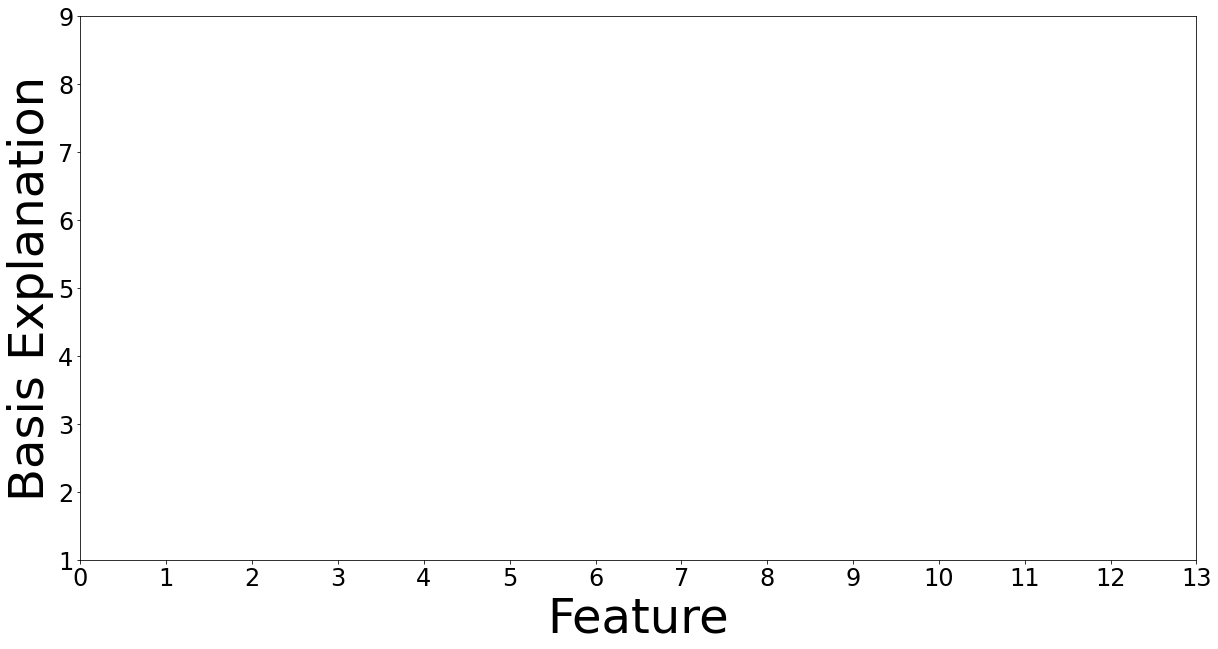

In [9]:
# Evaluate how much the other explanations changed

deltas_original = np.load("../Heart-K/deltas" + str(k) + ".npy")

plot_change(deltas, deltas_original, "heart-retrained-similarity.png", feature_names = feature_names)